In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Scripts import reverse_preprocessing_func as rv
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from skorch.regressor import NeuralNetRegressor
from Scripts import to_stationary as ts
from Scripts import dir_functions
from Scripts import metrics_plotting as mp
from Scripts import train_and_eval as train_eval
import os
import glob
import shutil
import json
import copy

torch.manual_seed(32)


d:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
results_folder = 'C:/Users/taina/OneDrive/Documentos/GitHub/TimeSeries-Forecasting/ONS/results/MLP/sudeste'
models_folder = 'C:/Users/taina/OneDrive/Documentos/GitHub/TimeSeries-Forecasting/ONS/models/MLP/sudeste'

if not os.path.exists(results_folder):
    os.mkdir(results_folder)
    
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

# Import Data

In [4]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')
#data = pd.read_pickle('ONS_preprocessed/df_sudeste_norm.pkl')

# Modeling

## Split into train an test

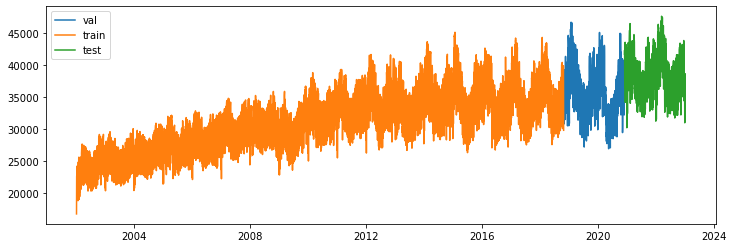

In [5]:
TEST_SIZE = 0.1
VAL_SIZE = 0.1
WINDOW_SIZE = 30

df_test = data[-round(TEST_SIZE*len(data)):]
df_train_val = data[:-round(TEST_SIZE*len(data))]
df_val = df_train_val[-round(VAL_SIZE*len(data)):]
df_train = df_train_val[:-round(VAL_SIZE*len(data))]

plt.figure(figsize=(12,4))
plt.plot(df_val.data, df_val.carga)
plt.plot(df_train.data, df_train.carga)
plt.plot(df_test.data, df_test.carga)
plt.legend(['val', 'train', 'test'])


## Prepare Dataset



In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [7]:
# window_size = dimensão da entrada (quantidade de lags utilizados)
def prepare_dataset(df, window_size=30, batch_size=32):
    consumption = df['carga'].values
    date = df['data'].values
    x = []
    y = []
    y_date = []

    dim = window_size

    for i in range(len(df)-dim):
        x.append(consumption[i:i+dim])
        y.append(consumption[i+dim])
        y_date.append(date[i+dim])

    x = torch.FloatTensor(x).reshape(-1,window_size)
    y = torch.FloatTensor(y).reshape(-1,1)
    dataset = TimeSeriesDataset(x,y)
    dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return x, y, y_date, dataset_loader

## MLP Model


In [8]:
class MLPmodel(nn.Module):
    def __init__(self,  n1, in_features=30, out_features=1):
        super().__init__()
        self.fc1 =  nn.Linear(in_features, n1)
        self.out = nn.Linear(n1, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

    def predict(self, x):
        y_pred = []
        with torch.no_grad():
            for i,data in enumerate(x):
                y_pred.append(np.array(self.forward(data)))
        return np.array(y_pred)

In [14]:
params = {
    'module__n1' : [10, 50, 100, 200],
    'lr' : [0.001, 0.005, 0.01]
}

params_grid = ParameterGrid(params)
list(params_grid)

[{'lr': 0.001, 'module__n1': 10},
 {'lr': 0.001, 'module__n1': 50},
 {'lr': 0.001, 'module__n1': 100},
 {'lr': 0.001, 'module__n1': 200},
 {'lr': 0.005, 'module__n1': 10},
 {'lr': 0.005, 'module__n1': 50},
 {'lr': 0.005, 'module__n1': 100},
 {'lr': 0.005, 'module__n1': 200},
 {'lr': 0.01, 'module__n1': 10},
 {'lr': 0.01, 'module__n1': 50},
 {'lr': 0.01, 'module__n1': 100},
 {'lr': 0.01, 'module__n1': 200}]

In [13]:
def save_results(results_path, metrics_dict, df_denorm_test_pred, best_model):
    dir_functions.create_results_folder(results_path)
    torch.save(best_model, results_path + '/best_model.pth')
    df_denorm_test_pred.to_pickle( results_path + '/predicted.pkl')
    with open(results_path + "/metrics.json", "w") as outfile:
        json.dump(metrics_dict, outfile)

    plt.figure(figsize=(5,5))
    sns.boxplot(y = metrics_dict['mape_list'])
    sns.stripplot(y = metrics_dict['mape_list'], color = 'black')
    plt.savefig('boxplot', dpi=300)

# Running different datasets

## 1 - Normalized series

In [15]:
df_test_norm = ts.normalize(df_test)
df_train_norm = ts.normalize(df_train)
df_val_norm = ts.normalize(df_val)
df_train_val_norm = ts.normalize(df_train_val)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

### Hyperparameter tuning

lr = 0.001, n1 = 10, min val mse epoch = 500, min val MSE = 0.18749345956291413, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 500, min val MSE = 0.1180617124352815, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 500, min val MSE = 0.11599066154459914, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 500, min val MSE = 0.10979061704777875, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 500, min val MSE = 0.1173259781240006, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 499, min val MSE = 0.1003098380399822, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 462, min val MSE = 0.10530257953444176, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 431, min val MSE = 0.09994876293645054, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 499, min val MSE = 0.11253818167219917, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 472, min val MSE = 0.09815438504150496, min val MAPE = 0
lr = 0.01, n1 = 100, 

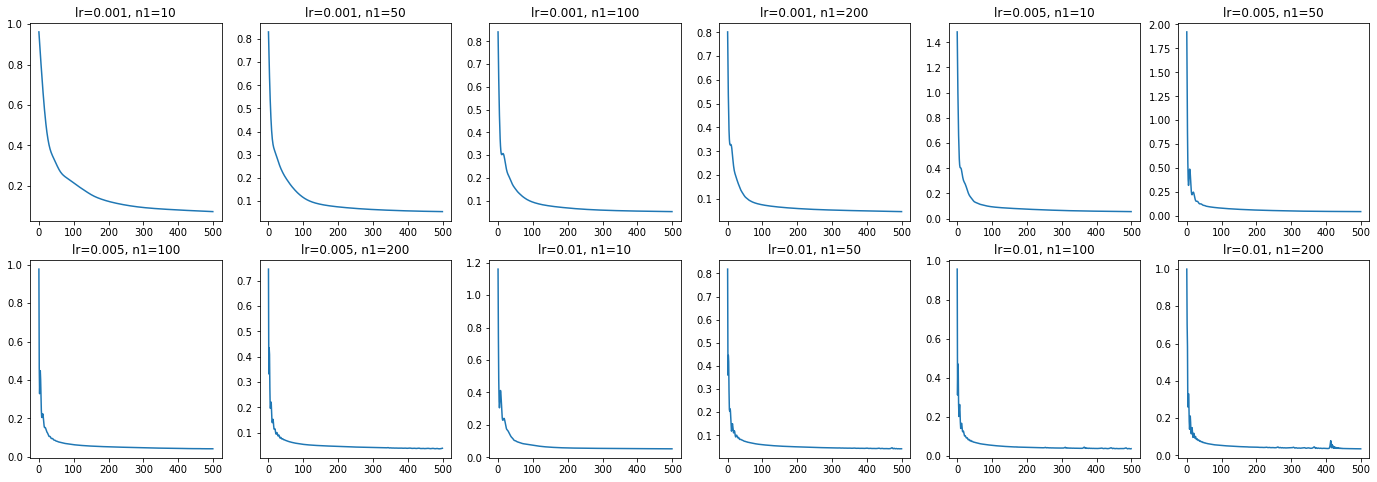

In [16]:
df_path_name = models_folder + '/df_norm'
data = {'train_loader': train_loader, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 
        'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date, 'df_val_norm': df_val_norm, 'val_loader': val_loader}

train_eval.training_and_tuning(MLPmodel,
                    data,
                    epochs=500, # 500
                    min_epoch_eval=430, # 430
                    df_path_name=df_path_name,
                    params_grid=params_grid,
                    plot_results=True)

### Evaluation

In [17]:
# Function passed as parameter to evaluation
# "Denormalize" series, returning to original scale
def denorm(df_test, y_test_pred, y_test_date, *args):
    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_denorm_test_pred = rv.reverse_norm(df_test, df_test_pred)
    return df_denorm_test_pred

In [18]:
# best model parameters
n1 = 50
lr = 0.01

df_path_name = models_folder + '/df_norm'

# More parameters passed to evaluation, mainly training, validation and test data, and other necessary parameters to denormalize
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader': train_loader, 'val_loader': val_loader}

# Run eval(s)
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(MLPmodel,
                                                                         n1, lr, data,
                                                                        epochs=500, #500
                                                                        df_path_name=df_path_name,
                                                                        n_eval=20,
                                                                        denorm=denorm,
                                                                        min_epoch_eval=450, #450
                                                                        verbose=True,
                                                                        denorm_kwargs={})

Treino = 0, Test MAPE = 0.0193559868993676
Treino = 1, Test MAPE = 0.01944129280844725
Treino = 2, Test MAPE = 0.01993756552255252
Treino = 3, Test MAPE = 0.019434270125739707
Treino = 4, Test MAPE = 0.01855840212465695
Treino = 5, Test MAPE = 0.019223912426226418
Treino = 6, Test MAPE = 0.018830331029984947
Treino = 7, Test MAPE = 0.019096228114356243
Treino = 8, Test MAPE = 0.018963371492893292
Treino = 9, Test MAPE = 0.01858976972747779
Treino = 10, Test MAPE = 0.019066271856628597
Treino = 11, Test MAPE = 0.019179269993946813
Treino = 12, Test MAPE = 0.02020097084202052
Treino = 13, Test MAPE = 0.01924022299427761
Treino = 14, Test MAPE = 0.018824181601371778
Treino = 15, Test MAPE = 0.01917149017884786
Treino = 16, Test MAPE = 0.01901362572307192
Treino = 17, Test MAPE = 0.01962267519982881
Treino = 18, Test MAPE = 0.018552797712483783
Treino = 19, Test MAPE = 0.018751179776370946


Test
{'mse': 1201480.488696729, 'mape': 0.019143293767510915}


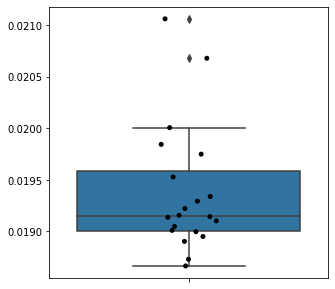

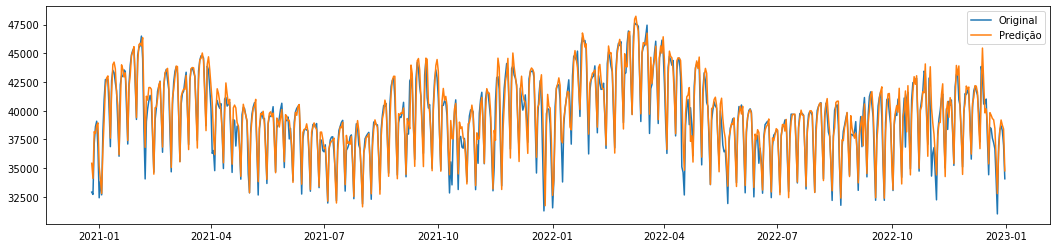

In [51]:
save_results(results_folder + '/df_norm', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 3 - Original series without trend by curve fitting

In [53]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_fit, coefs_test = ts.trend_fit_curve(df_test)
df_train_fit, coefs_train = ts.trend_fit_curve(df_train)
df_val_fit, coefs_val = ts.trend_fit_curve(df_val)
data_fit, coefs_data = ts.trend_fit_curve(data)

df_test_norm = ts.normalize(df_test_fit)
df_train_norm = ts.normalize(df_train_fit)
df_val_norm = ts.normalize(df_val_fit)
data_norm = ts.normalize(data_fit)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

lr = 0.001, n1 = 10, min val mse epoch = 500, min val MSE = 0.16034356858196688, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 500, min val MSE = 0.13047283649335126, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 500, min val MSE = 0.12360322875683948, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 500, min val MSE = 0.12460876959629552, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 439, min val MSE = 0.12307143427092701, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 430, min val MSE = 0.12058273954872886, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 443, min val MSE = 0.12345745958541166, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 436, min val MSE = 0.127527882804859, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 446, min val MSE = 0.1180904732928205, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 431, min val MSE = 0.12562661030039013, min val MAPE = 0
lr = 0.01, n1 = 100, 

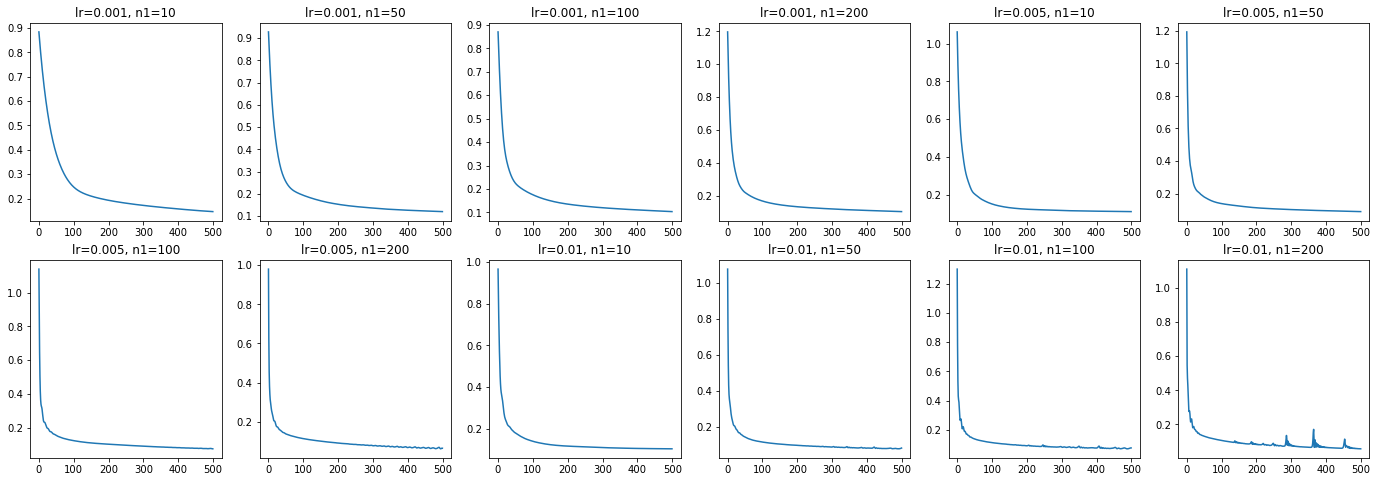

In [54]:
df_path_name = models_folder + '/df_fit_curve'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'val_loader':val_loader, 'train_loader':train_loader}
denorm_kwargs = {'df_train_fit': df_train_fit, 'df_test_fit': df_val_fit, 'coefs_train': coefs_train, 'coefs_test': coefs_val}

train_eval.training_and_tuning(data,
                    epochs=500,
                    min_epoch_eval=430,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [55]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_trend_test_pred = rv.reverse_norm(my_args['df_test_fit'], df_test_pred)
    df_trend_test_pred = rv.reverse_trend_fit(df_trend_test_pred, my_args['coefs_test'])

    return df_trend_test_pred

In [56]:
# best model parameters
n1 = 10
lr = 0.005

df_path_name = models_folder + '/df_fit_curve'

data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_test_fit': df_test_fit, 'coefs_test': coefs_test}


# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=500,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=430,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.02122685023970619
Treino = 1, Test MAPE = 0.021310895407138545
Treino = 2, Test MAPE = 0.021572080452700308
Treino = 3, Test MAPE = 0.021449844495821227
Treino = 4, Test MAPE = 0.02205119314628246
Treino = 5, Test MAPE = 0.021248351411757578
Treino = 6, Test MAPE = 0.021305472755928718
Treino = 7, Test MAPE = 0.022043465707405265
Treino = 8, Test MAPE = 0.021031128939962396
Treino = 9, Test MAPE = 0.021161866803158066
Treino = 10, Test MAPE = 0.021850234652041514
Treino = 11, Test MAPE = 0.02078936801605288
Treino = 12, Test MAPE = 0.021529568552330954
Treino = 13, Test MAPE = 0.02112612984884305
Treino = 14, Test MAPE = 0.02131797476973996
Treino = 15, Test MAPE = 0.02170376463628271
Treino = 16, Test MAPE = 0.020995654664824216
Treino = 17, Test MAPE = 0.021295017749649457
Treino = 18, Test MAPE = 0.021555763729226123
Treino = 19, Test MAPE = 0.020880113255068618


Test
{'mse': 1291547.9428709787, 'mape': 0.020880113255068618}


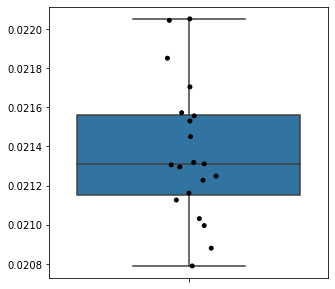

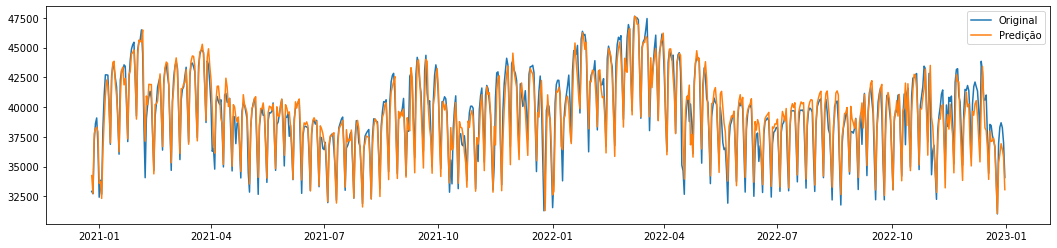

In [57]:
save_results(results_folder + '/df_fit_curve', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 4 - Original series without trend by differencing

In [58]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_diff = ts.trend_diff(df_test)
df_train_diff = ts.trend_diff(df_train)
df_val_diff = ts.trend_diff(df_val)
data_diff = ts.trend_diff(data)

df_test_norm = ts.normalize(df_test_diff)
df_train_norm = ts.normalize(df_train_diff)
df_val_norm = ts.normalize(df_val_diff)
data_norm = ts.normalize(data_diff)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

lr = 0.001, n1 = 10, min val mse epoch = 500, min val MSE = 0.20735503809860595, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 500, min val MSE = 0.19988986085027935, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 454, min val MSE = 0.18636449365469096, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 450, min val MSE = 0.18409071220396406, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 430, min val MSE = 0.19949584859397262, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 462, min val MSE = 0.18874703124612896, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 430, min val MSE = 0.19331639710115436, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 431, min val MSE = 0.19080695180633309, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 447, min val MSE = 0.1927126655319256, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 431, min val MSE = 0.18465261171292802, min val MAPE = 0
lr = 0.01, n1 = 100

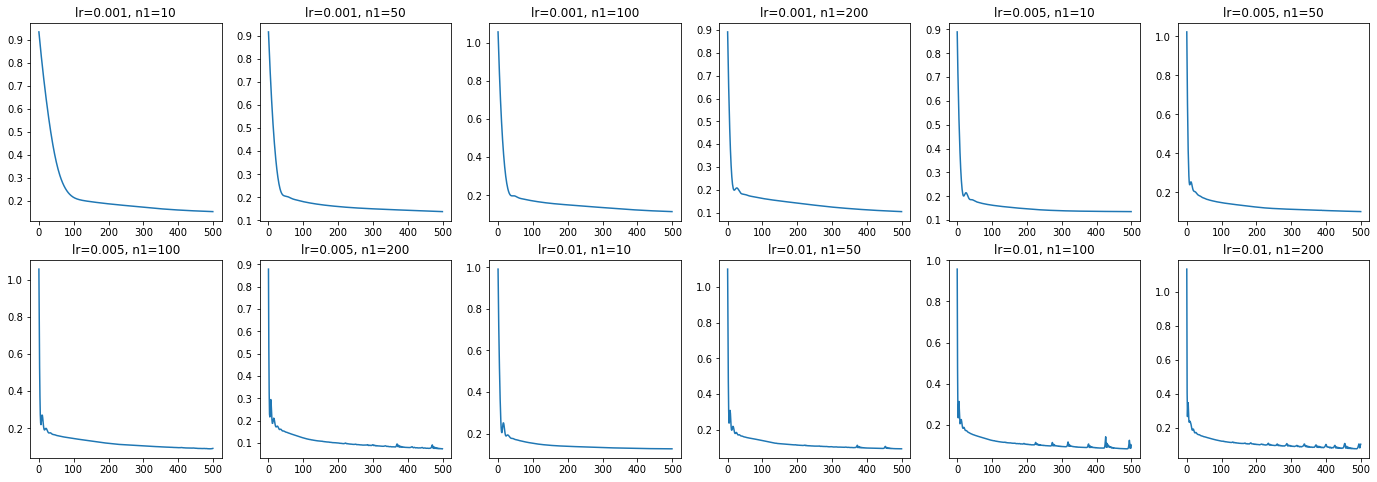

In [59]:
df_path_name = models_folder + '/df_trend_diff'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=500,
                    min_epoch_eval=430,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [60]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_diff'], df_test_pred)
    df_test_pred = rv.reverse_trend_diff(df_test, df_test_pred)

    return df_test_pred

In [61]:
# best model parameters
n1 = 200
lr = 0.001

df_path_name = models_folder + 'df_trend_diff'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_train': df_train_val, 'df_test': df_val, 'df_test_diff': df_test_diff}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=500,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=430,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.018387381076365155
Treino = 1, Test MAPE = 0.018213995133635943
Treino = 2, Test MAPE = 0.01815837912694296
Treino = 3, Test MAPE = 0.018053042927826776
Treino = 4, Test MAPE = 0.018505531532356588
Treino = 5, Test MAPE = 0.01776824660581163
Treino = 6, Test MAPE = 0.01825798531216638
Treino = 7, Test MAPE = 0.017997245859486876
Treino = 8, Test MAPE = 0.01812728127872186
Treino = 9, Test MAPE = 0.01809099195239926
Treino = 10, Test MAPE = 0.01792682472297282
Treino = 11, Test MAPE = 0.018080522869078526
Treino = 12, Test MAPE = 0.018121169093021017
Treino = 13, Test MAPE = 0.01794235157052069
Treino = 14, Test MAPE = 0.01810759590103503
Treino = 15, Test MAPE = 0.018465310933123237
Treino = 16, Test MAPE = 0.018169918126046264
Treino = 17, Test MAPE = 0.017927225551413333
Treino = 18, Test MAPE = 0.018166574245424956
Treino = 19, Test MAPE = 0.01816113676455537


Test
{'mse': 1064774.653653948, 'mape': 0.01816113676455537}


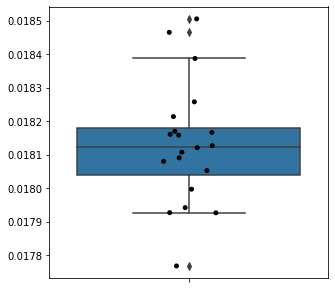

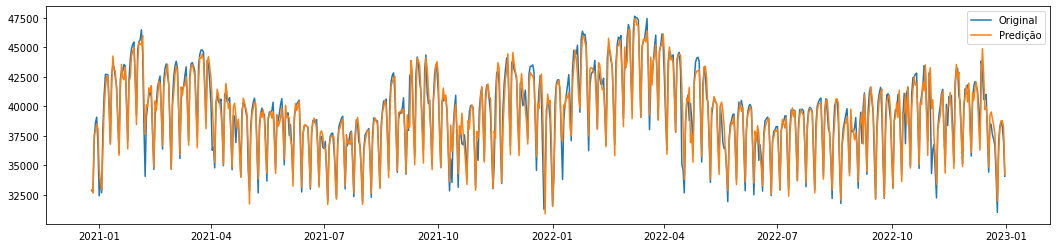

In [62]:
save_results(results_folder + '/df_trend_diff', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 5 - Original series without seasonality by normalization

In [65]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_norm, year_test_mean, year_test_std = ts.season_padronization(df_test, 'year')
df_train_norm, year_train_mean, year_train_std = ts.season_padronization(df_train, 'year')
df_val_norm, year_val_mean, year_val_std = ts.season_padronization(df_val, 'year')
data_norm, year_data_mean, year_data_std = ts.season_padronization(data, 'year')

df_test_norm, week_test_mean, week_test_std = ts.season_padronization(df_test_norm, 'week')
df_train_norm, week_train_mean, week_train_std = ts.season_padronization(df_train_norm, 'week')
df_val_norm, week_val_mean, week_val_std = ts.season_padronization(df_val_norm, 'week')
data_norm, week_data_mean, week_data_std = ts.season_padronization(data_norm, 'week')

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

C:\Users\taina\AppData\Local\Temp/ipykernel_15236/374385274.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  x = torch.FloatTensor(x).reshape(-1,window_size)


(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

lr = 0.001, n1 = 10, min val mse epoch = 500, min val MSE = 0.7702185785599084, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 500, min val MSE = 0.713243053813484, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 400, min val MSE = 0.7652170754258961, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 400, min val MSE = 0.7579592891985117, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 400, min val MSE = 0.730341875201291, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 400, min val MSE = 0.7868630810648348, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 401, min val MSE = 0.8114001018717719, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 401, min val MSE = 0.8086375263463603, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 400, min val MSE = 0.8098201805059552, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 400, min val MSE = 0.814168791578824, min val MAPE = 0
lr = 0.01, n1 = 100, min val ms

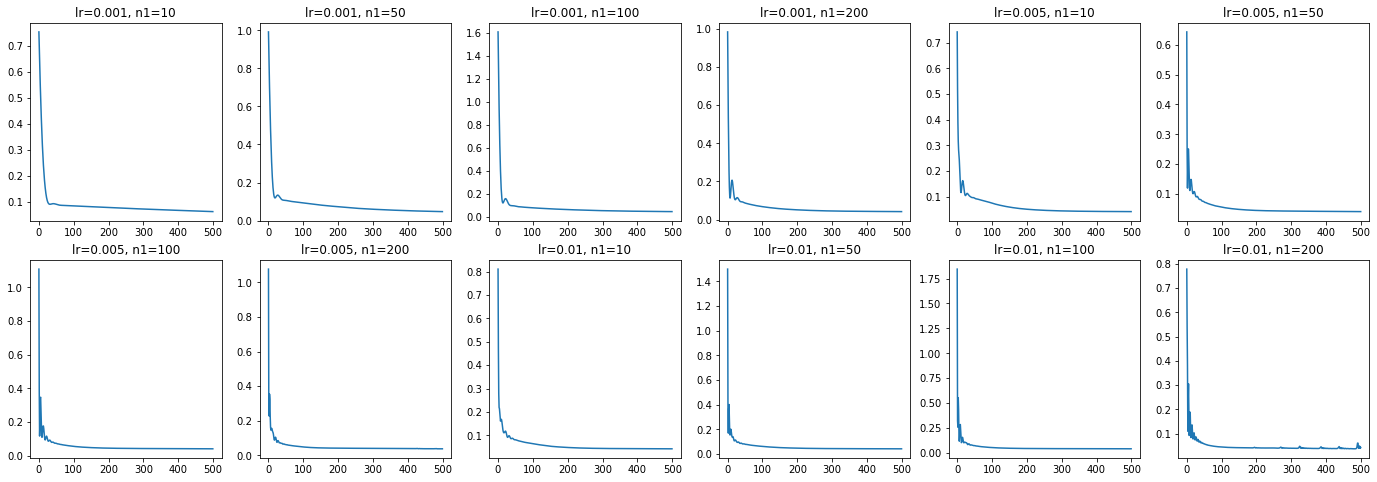

In [66]:
df_path_name = models_folder + '/df_desazon_pad'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=500,
                    min_epoch_eval=400,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [67]:
def denorm(df_test,y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred  = rv.add_sazon_pad(df_test_pred, my_args['week_test_mean'], my_args['week_test_std'], 'week')
    df_test_pred  = rv.add_sazon_pad(df_test_pred , my_args['year_test_mean'], my_args['year_test_std'], 'year')

    return df_test_pred

In [68]:
# best model parameters
n1 = 50
lr = 0.001

df_path_name = models_folder + '/df_desazon_pad'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'week_test_mean': week_test_mean, 'week_test_std': week_test_std,'year_test_mean': year_test_mean, 'year_test_std': year_test_std}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=500,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=400,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.018164756298774988
Treino = 1, Test MAPE = 0.017999165883781337
Treino = 2, Test MAPE = 0.018249499486093546
Treino = 3, Test MAPE = 0.018420456462643543
Treino = 4, Test MAPE = 0.01824602978633684
Treino = 5, Test MAPE = 0.01730656565428057
Treino = 6, Test MAPE = 0.01770107504126174
Treino = 7, Test MAPE = 0.01827567572855703
Treino = 8, Test MAPE = 0.017889838630826514
Treino = 9, Test MAPE = 0.017326074251933665
Treino = 10, Test MAPE = 0.017490224814101254
Treino = 11, Test MAPE = 0.01778033129119328
Treino = 12, Test MAPE = 0.018112508344015402
Treino = 13, Test MAPE = 0.019010310012160112
Treino = 14, Test MAPE = 0.01822978737383961
Treino = 15, Test MAPE = 0.017107429760132412
Treino = 16, Test MAPE = 0.01853940482347166
Treino = 17, Test MAPE = 0.017698210830844642
Treino = 18, Test MAPE = 0.017929893613291746
Treino = 19, Test MAPE = 0.01723705531886379


Test
{'mse': 1274790.2349138474, 'mape': 0.01723705531886379}


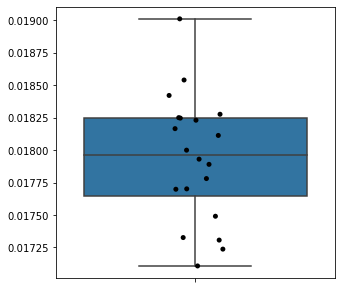

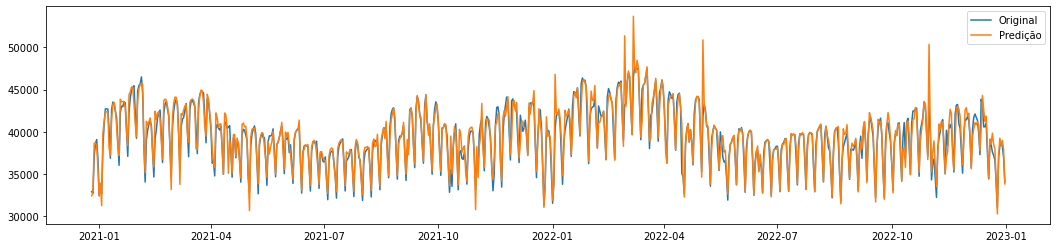

In [69]:
save_results(results_folder + '/df_desazon_pad', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 6 - Original series without seasonality by moving average

In [70]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_ma, month_test_mean = ts.season_MA(df_test, 'month')
df_train_ma, month_train_mean = ts.season_MA(df_train, 'month')
df_val_ma, month_val_mean = ts.season_MA(df_val, 'month')
data_ma, month_data_mean = ts.season_MA(data, 'month')
df_test_ma, weekday_test_mean = ts.season_MA(df_test_ma, 'weekday')
df_train_ma, weekday_train_mean = ts.season_MA(df_train_ma, 'weekday')
df_val_ma, weekday_val_mean = ts.season_MA(df_val_ma, 'weekday')
data_ma, weekday_data_mean = ts.season_MA(data_ma, 'weekday')

df_test_norm = ts.normalize(df_test_ma)
df_train_norm = ts.normalize(df_train_ma)
df_val_norm = ts.normalize(df_val_ma)
data_norm = ts.normalize(data_ma)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

lr = 0.001, n1 = 10, min val mse epoch = 500, min val MSE = 0.509966433941447, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 500, min val MSE = 0.4325045805506698, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 500, min val MSE = 0.36973117374694786, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 500, min val MSE = 0.3721123979530133, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 500, min val MSE = 0.3523387830037642, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 401, min val MSE = 0.3711072691366887, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 401, min val MSE = 0.37146034371956693, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 400, min val MSE = 0.3668742889932381, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 400, min val MSE = 0.34183673464419967, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 412, min val MSE = 0.36579618231906347, min val MAPE = 0
lr = 0.01, n1 = 100, min 

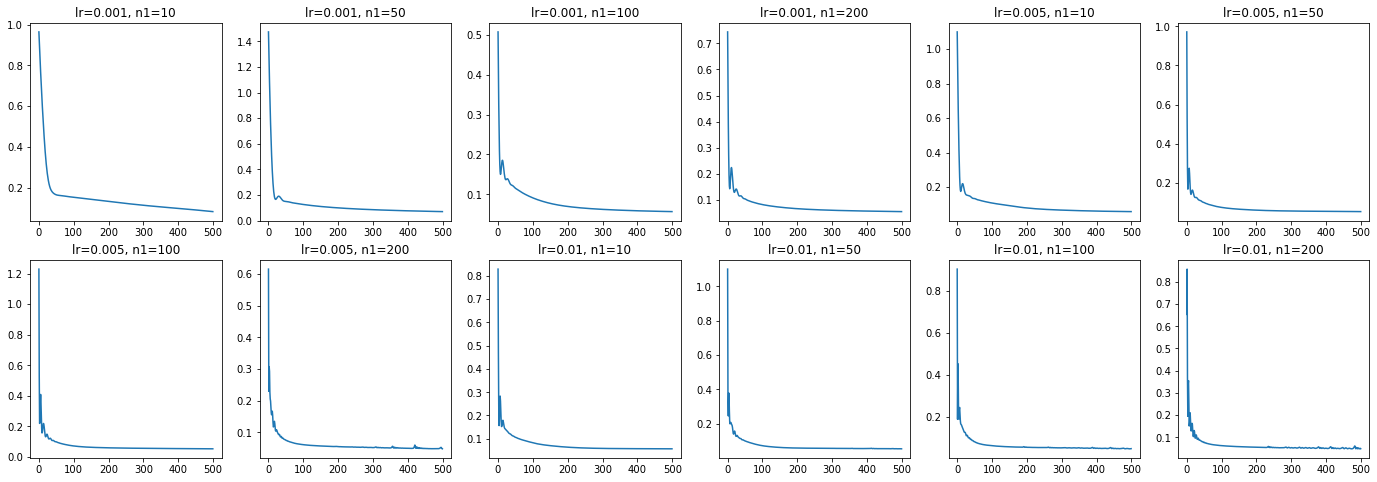

In [71]:
df_path_name = models_folder + '/df_desazon_MA'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=500,
                    min_epoch_eval=400,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [72]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_ma'], df_test_pred)
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['weekday_test_mean'], 'weekday')
    df_test_pred= rv.add_sazon_MA(df_test_pred, my_args['month_test_mean'], 'month')

    return df_test_pred

In [73]:
# best model parameters
n1 = 10
lr = 0.001

df_path_name = models_folder + '/df_desazon_MA'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_test_ma': df_test_ma, 'weekday_test_mean': weekday_test_mean, 'month_test_mean': month_test_mean}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=550,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=500,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.027497862766712622
Treino = 1, Test MAPE = 0.02328539462138843
Treino = 2, Test MAPE = 0.025554284013456757
Treino = 3, Test MAPE = 0.027226130252090246
Treino = 4, Test MAPE = 0.025324445415936002
Treino = 5, Test MAPE = 0.02504737053840189
Treino = 6, Test MAPE = 0.02218002234695012
Treino = 7, Test MAPE = 0.02704510818718379
Treino = 8, Test MAPE = 0.023294388520837254
Treino = 9, Test MAPE = 0.022821784133677147
Treino = 10, Test MAPE = 0.025130441667334736
Treino = 11, Test MAPE = 0.026515779256592324
Treino = 12, Test MAPE = 0.027497670962717477
Treino = 13, Test MAPE = 0.027796256467669023
Treino = 14, Test MAPE = 0.023769795451513104
Treino = 15, Test MAPE = 0.023759298651553646
Treino = 16, Test MAPE = 0.026195696035585754
Treino = 17, Test MAPE = 0.026551824769823203
Treino = 18, Test MAPE = 0.02560868294916822
Treino = 19, Test MAPE = 0.02577640702422189


Test
{'mse': 2020787.2004175873, 'mape': 0.02577640702422189}


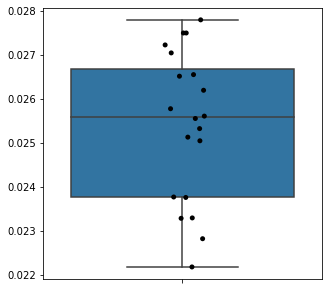

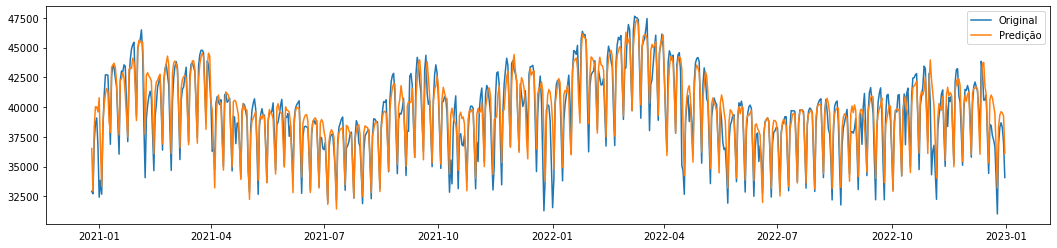

In [74]:
save_results(results_folder + '/df_desazon_MA', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 8 - Original series without trend by curve fitting and without seasonality by normalization

In [75]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_norm, coefs_test = ts.trend_fit_curve(df_test)
df_train_norm, coefs_train = ts.trend_fit_curve(df_train)
df_val_norm, coefs_val = ts.trend_fit_curve(df_val)
data_norm, coefs_data = ts.trend_fit_curve(data)

df_test_norm, year_test_mean, year_test_std = ts.season_padronization(df_test_norm, 'year')
df_train_norm, year_train_mean, year_train_std = ts.season_padronization(df_train_norm, 'year')
df_val_norm, year_val_mean, year_val_std = ts.season_padronization(df_val_norm, 'year')
data_norm, year_data_mean, year_data_std = ts.season_padronization(data_norm, 'year')

df_test_norm, week_test_mean, week_test_std = ts.season_padronization(df_test_norm, 'week')
df_train_norm, week_train_mean, week_train_std = ts.season_padronization(df_train_norm, 'week')
df_val_norm, week_val_mean, week_val_std = ts.season_padronization(df_val_norm, 'week')
data_norm, week_data_mean, week_data_std = ts.season_padronization(data_norm, 'week')


x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

lr = 0.001, n1 = 10, min val mse epoch = 500, min val MSE = 0.7550558771437008, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 500, min val MSE = 0.8100615381880176, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 500, min val MSE = 0.8102725252087848, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 500, min val MSE = 0.8738282834753588, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 500, min val MSE = 0.7804779125942608, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 508, min val MSE = 0.8796397698543466, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 503, min val MSE = 1.0086177073215072, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 501, min val MSE = 0.9783946870756235, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 596, min val MSE = 0.802495634364436, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 500, min val MSE = 0.9434443660814765, min val MAPE = 0
lr = 0.01, n1 = 100, min val 

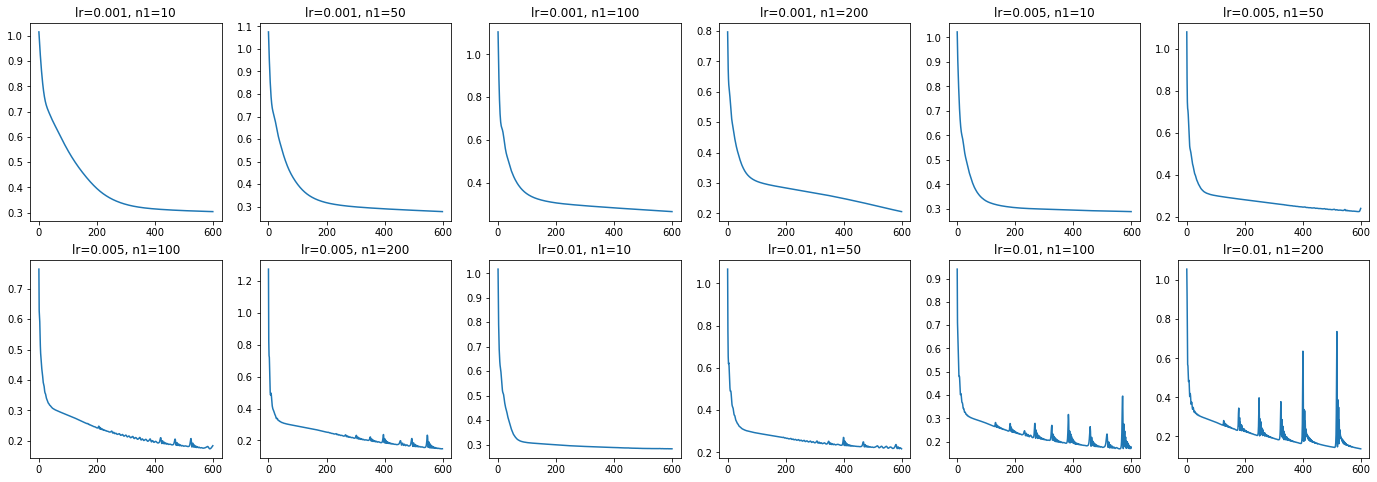

In [76]:
df_path_name = models_folder + '/df_fit_pad'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}


train_eval.training_and_tuning(data,
                    epochs=600,
                    min_epoch_eval=500,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [77]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['week_test_mean'], my_args['week_test_std'], 'week')
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['year_test_mean'], my_args['year_test_std'], 'year')
    df_test_pred = rv.reverse_trend_fit(df_test_pred, my_args['coefs_test'])

    return df_test_pred

In [78]:
# best model parameters
n1 = 10
lr = 0.001

df_path_name = models_folder + '/df_fit_pad'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'week_test_mean': week_test_mean, 'week_test_std': week_test_std, 'year_test_mean': year_test_mean, 'year_test_std': year_test_std, \
                    'coefs_test': coefs_test}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=520,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=450,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.021056374499871394
Treino = 1, Test MAPE = 0.021013886500082676
Treino = 2, Test MAPE = 0.02072002525607414
Treino = 3, Test MAPE = 0.020766417491456524
Treino = 4, Test MAPE = 0.020847310473952337
Treino = 5, Test MAPE = 0.020208297748894998
Treino = 6, Test MAPE = 0.020373939231958998
Treino = 7, Test MAPE = 0.02062756764947525
Treino = 8, Test MAPE = 0.02063259988330229
Treino = 9, Test MAPE = 0.02110123146780271
Treino = 10, Test MAPE = 0.020559446110318184
Treino = 11, Test MAPE = 0.02060373217300429
Treino = 12, Test MAPE = 0.02060958517648875
Treino = 13, Test MAPE = 0.02067687714782201
Treino = 14, Test MAPE = 0.02122296321666749
Treino = 15, Test MAPE = 0.020699121736741682
Treino = 16, Test MAPE = 0.02068252228244765
Treino = 17, Test MAPE = 0.020892536899275033
Treino = 18, Test MAPE = 0.02047846755350335
Treino = 19, Test MAPE = 0.020802143766868213


Test
{'mse': 1669147.8630978093, 'mape': 0.020802143766868213}


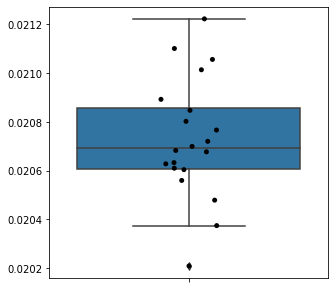

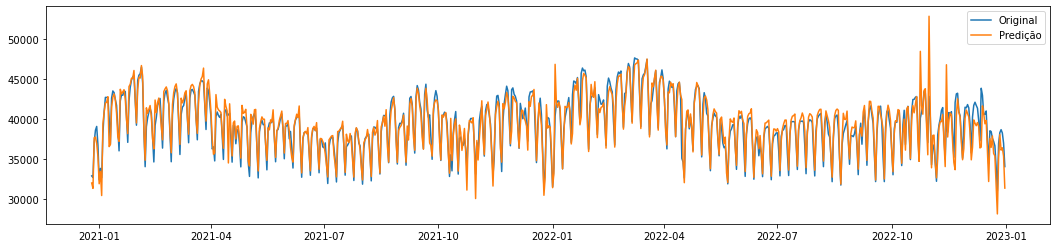

In [79]:
save_results(results_folder + '/df_fit_pad', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 9 - Original series without trend by curve fitting and without seasonality by moving avegrage

In [80]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_fit, coefs_test = ts.trend_fit_curve(df_test)
df_train_fit, coefs_train = ts.trend_fit_curve(df_train)
df_val_fit, coefs_val = ts.trend_fit_curve(df_val)
data_fit, coefs_train_val = ts.trend_fit_curve(data)


df_test_ma, month_test_mean = ts.season_MA(df_test_fit, 'month')
df_train_ma, month_train_mean = ts.season_MA(df_train_fit, 'month')
df_val_ma, month_val_mean = ts.season_MA(df_val_fit, 'month')
data_ma, month_data_mean = ts.season_MA(data_fit, 'month')

df_test_ma, weekday_test_mean = ts.season_MA(df_test_ma, 'weekday')
df_train_ma, weekday_train_mean = ts.season_MA(df_train_ma, 'weekday')
df_val_ma, weekday_val_mean = ts.season_MA(df_val_ma, 'weekday')
data_ma, weekday_data_mean = ts.season_MA(data_ma, 'weekday')


df_test_norm = ts.normalize(df_test_ma)
df_train_norm = ts.normalize(df_train_ma)
df_val_norm = ts.normalize(df_val_ma)
data_norm = ts.normalize(data_ma)


x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

lr = 0.001, n1 = 10, min val mse epoch = 600, min val MSE = 0.31974898377781774, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 500, min val MSE = 0.3086285926763729, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 500, min val MSE = 0.31988535827651804, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 500, min val MSE = 0.3157790719479892, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 600, min val MSE = 0.3016448613304398, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 500, min val MSE = 0.33341832632044244, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 500, min val MSE = 0.34023172311325195, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 504, min val MSE = 0.3629959658352739, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 504, min val MSE = 0.3063871060935261, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 500, min val MSE = 0.3226516767028651, min val MAPE = 0
lr = 0.01, n1 = 100, min

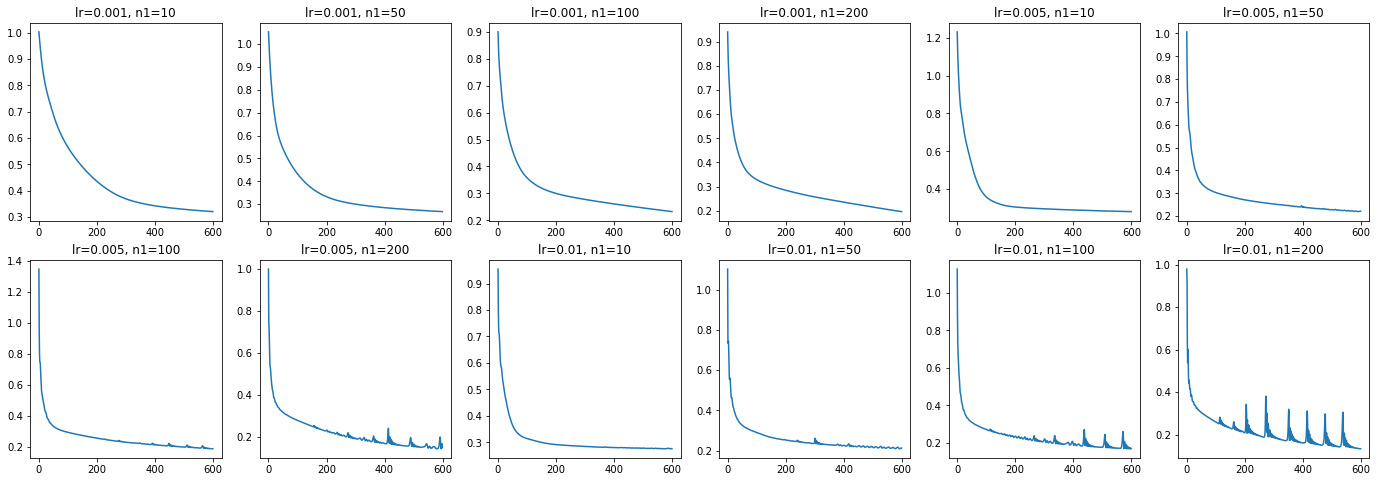

In [81]:
df_path_name=models_folder + '/df_fit_MA'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=600,
                    min_epoch_eval=500,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [82]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_ma'], df_test_pred)
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['weekday_test_mean'], 'weekday')
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['month_test_mean'], 'month')
    df_test_pred = rv.reverse_trend_fit(df_test_pred, my_args['coefs_test'])

    return df_test_pred

In [72]:
# best model parameters
n1 = 100
lr = 0.001

df_path_name = models_folder + '/df_fit_MA'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_test_ma': df_test_ma, 'weekday_test_mean': weekday_test_mean, 'month_test_mean': month_test_mean, \
                   'coefs_test': coefs_test, 'coefs_train': coefs_train_val}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=550,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=480,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.02138147712578004
Treino = 1, Test MAPE = 0.021483069690086672
Treino = 2, Test MAPE = 0.020893710710132195
Treino = 3, Test MAPE = 0.021851308016795613
Treino = 4, Test MAPE = 0.0209831660995995
Treino = 5, Test MAPE = 0.02197019137486072
Treino = 6, Test MAPE = 0.021097463524642403
Treino = 7, Test MAPE = 0.021380929894180074
Treino = 8, Test MAPE = 0.021867696017248833
Treino = 9, Test MAPE = 0.02098321507635365
Treino = 10, Test MAPE = 0.021230580265668483
Treino = 11, Test MAPE = 0.020967517367197312
Treino = 12, Test MAPE = 0.02151896560285211
Treino = 13, Test MAPE = 0.021344926375857887
Treino = 14, Test MAPE = 0.02111717573816019
Treino = 15, Test MAPE = 0.021439557792666784
Treino = 16, Test MAPE = 0.020746217954017595
Treino = 17, Test MAPE = 0.020948397774284117
Treino = 18, Test MAPE = 0.021012335894925665
Treino = 19, Test MAPE = 0.02109475601135446


Test
{'mse': 1669147.8630978093, 'mape': 0.020802143766868213}


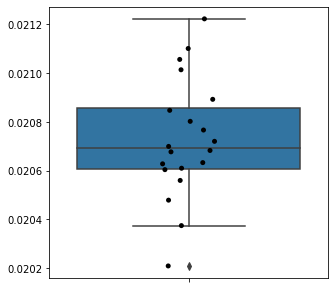

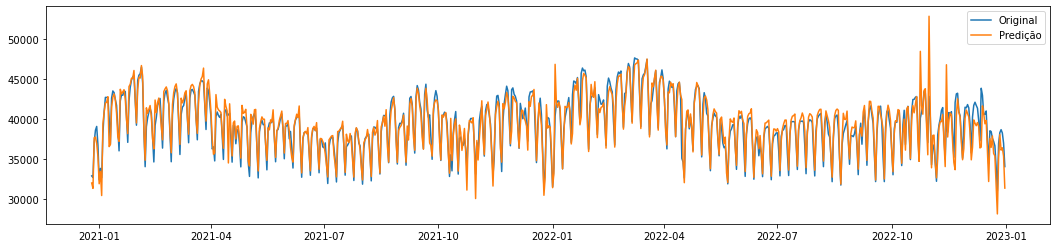

In [83]:
save_results(results_folder + '/df_fit_MA', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 10 - Original Series without trend by differencing and without seasonality by differencing

In [84]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_diff = ts.trend_diff(df_test)
df_train_diff = ts.trend_diff(df_train)
df_val_diff = ts.trend_diff(df_val)
data_diff = ts.trend_diff(data)

df_test_norm, year_test_mean, year_test_std = ts.season_padronization(df_test_diff, 'year')
df_train_norm, year_train_mean, year_train_std = ts.season_padronization(df_train_diff, 'year')
df_val_norm, year_val_mean, year_val_std = ts.season_padronization(df_val_diff, 'year')
data_norm, year_data_mean, year_data_std = ts.season_padronization(data_diff, 'year')


df_test_norm, week_test_mean, week_test_std = ts.season_padronization(df_test_norm, 'week')
df_train_norm, week_train_mean, week_train_std = ts.season_padronization(df_train_norm, 'week')
df_val_norm, week_val_mean, week_val_std = ts.season_padronization(df_val_norm, 'week')
data_norm, week_data_mean, week_data_std = ts.season_padronization(data_norm, 'week')

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

In [85]:
def denorm(df_test,y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['week_test_mean'], my_args['week_test_std'], 'week')
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['year_test_mean'], my_args['year_test_std'], 'year')
    df_test_pred = rv.reverse_trend_diff(my_args['df_test'], df_test_pred)

    return df_test_pred

lr = 0.001, n1 = 10, min val mse epoch = 726, min val MSE = 0.9132417958877453, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 700, min val MSE = 1.1959161869594799, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 700, min val MSE = 1.3743986531600756, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 700, min val MSE = 1.6922942497799272, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 746, min val MSE = 0.8916445410215874, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 712, min val MSE = 1.4406059938166842, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 702, min val MSE = 1.628714300515147, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 700, min val MSE = 1.7734348895413583, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 795, min val MSE = 0.8880162421116209, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 790, min val MSE = 1.3398342940707253, min val MAPE = 0
lr = 0.01, n1 = 100, min val 

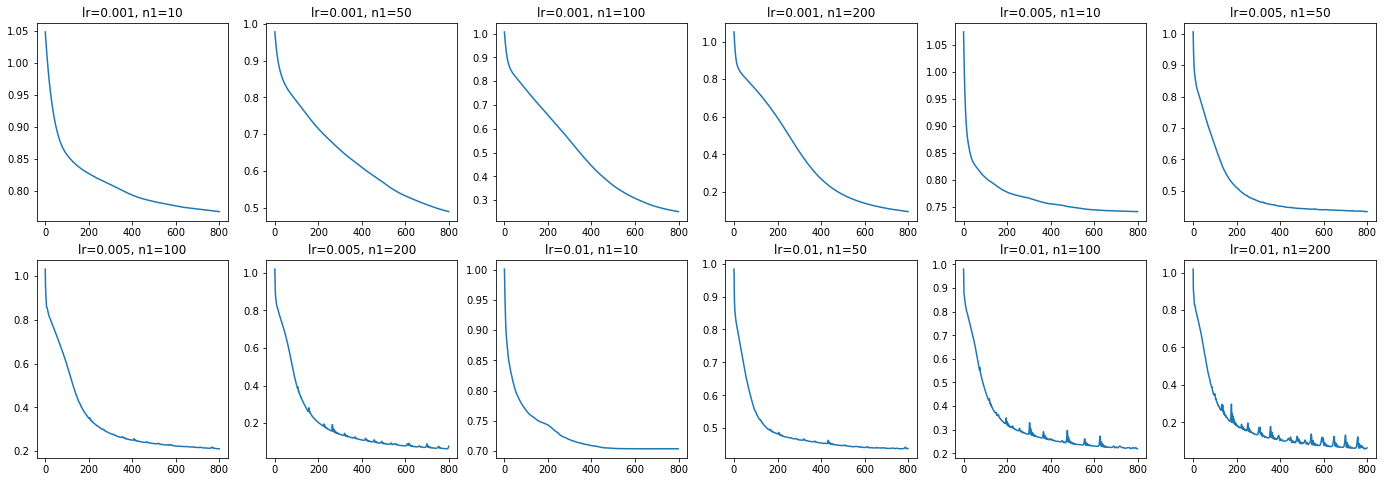

In [86]:
df_path_name=models_folder + '/df_diff_pad'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=800,
                    min_epoch_eval=700,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [87]:
# best model parameters
n1 = 10
lr = 0.01

df_path_name = models_folder + '/df_diff_pad'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_test': df_test, 'df_train': df_train_val, 'week_test_mean': week_test_mean, 'week_test_std': week_test_std, \
                   'year_test_mean': year_test_mean, 'year_test_std': year_test_std}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=720,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=650,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.016661770736802386
Treino = 1, Test MAPE = 0.016272537764729776
Treino = 2, Test MAPE = 0.015954987834247213
Treino = 3, Test MAPE = 0.017632783443493
Treino = 4, Test MAPE = 0.01609119306257151
Treino = 5, Test MAPE = 0.016390313211231064
Treino = 6, Test MAPE = 0.01638044094012142
Treino = 7, Test MAPE = 0.01713146249384234
Treino = 8, Test MAPE = 0.016383526427053773
Treino = 9, Test MAPE = 0.01676194597380884
Treino = 10, Test MAPE = 0.01610932298983574
Treino = 11, Test MAPE = 0.016338293332954775
Treino = 12, Test MAPE = 0.015153284032213723
Treino = 13, Test MAPE = 0.01701349259893995
Treino = 14, Test MAPE = 0.01668001345356519
Treino = 15, Test MAPE = 0.017756778063071944
Treino = 16, Test MAPE = 0.01675851442586606
Treino = 17, Test MAPE = 0.016455243178849194
Treino = 18, Test MAPE = 0.01670310573296001
Treino = 19, Test MAPE = 0.015882871787463185


Test
{'mse': 883020.6975375931, 'mape': 0.015882871787463185}


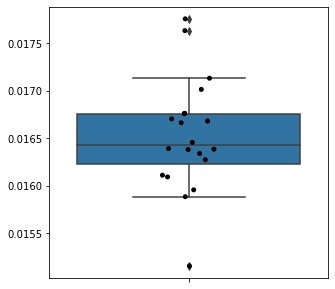

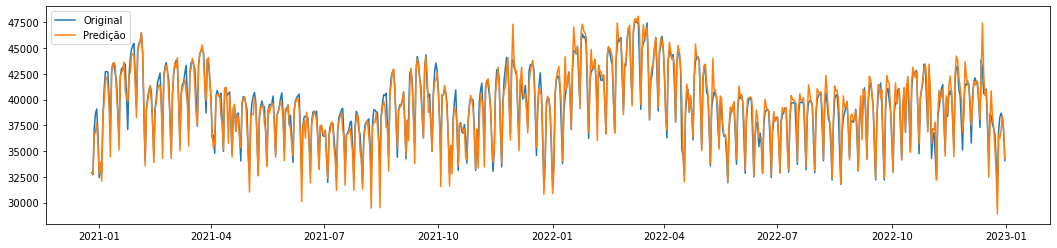

In [88]:
save_results(results_folder + '/df_diff_pad', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 11 - Original series without trend by differencing and without seasonality by moving average

In [89]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_diff = ts.trend_diff(df_test)
df_train_diff = ts.trend_diff(df_train)
df_val_diff = ts.trend_diff(df_val)
data_diff = ts.trend_diff(data)

df_test_ma, month_test_mean = ts.season_MA(df_test_diff, 'month')
df_train_ma, month_train_mean = ts.season_MA(df_train_diff, 'month')
df_val_ma, month_val_mean = ts.season_MA(df_val_diff, 'month')
data_ma, month_data_mean = ts.season_MA(data_diff, 'month')

df_test_ma, weekday_test_mean = ts.season_MA(df_test_ma, 'weekday')
df_train_ma, weekday_train_mean = ts.season_MA(df_train_ma, 'weekday')
df_val_ma, weekday_val_mean = ts.season_MA(df_val_ma, 'weekday')
data_ma, weekday_data_mean = ts.season_MA(data_ma, 'weekday')

df_test_norm = ts.normalize(df_test_ma)
df_train_norm = ts.normalize(df_train_ma)
df_val_norm = ts.normalize(df_val_ma)
data_norm = ts.normalize(data_ma)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))


x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30]),
 torch.Size([736, 30]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30]))

lr = 0.001, n1 = 10, min val mse epoch = 800, min val MSE = 0.8203774304274934, min val MAPE = 0
lr = 0.001, n1 = 50, min val mse epoch = 700, min val MSE = 0.9698913545967762, min val MAPE = 0
lr = 0.001, n1 = 100, min val mse epoch = 700, min val MSE = 1.089615387005078, min val MAPE = 0
lr = 0.001, n1 = 200, min val mse epoch = 700, min val MSE = 1.1083814455984022, min val MAPE = 0
lr = 0.005, n1 = 10, min val mse epoch = 794, min val MSE = 0.8806161363745764, min val MAPE = 0
lr = 0.005, n1 = 50, min val mse epoch = 704, min val MSE = 1.1375665415879512, min val MAPE = 0
lr = 0.005, n1 = 100, min val mse epoch = 711, min val MSE = 1.4830444078413973, min val MAPE = 0
lr = 0.005, n1 = 200, min val mse epoch = 700, min val MSE = 1.3237119982281127, min val MAPE = 0
lr = 0.01, n1 = 10, min val mse epoch = 765, min val MSE = 0.8838707516402262, min val MAPE = 0
lr = 0.01, n1 = 50, min val mse epoch = 756, min val MSE = 1.1665687500159037, min val MAPE = 0
lr = 0.01, n1 = 100, min val 

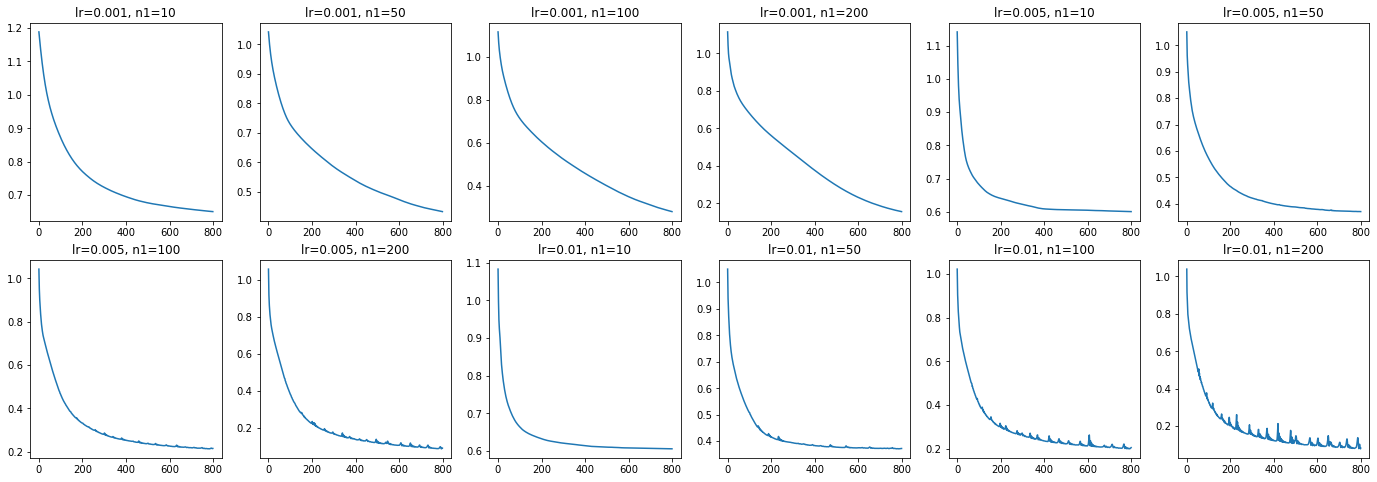

In [90]:
df_path_name=models_folder + '/df_diff_MA'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=800,
                    min_epoch_eval=700,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [91]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_ma'], df_test_pred)
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['weekday_test_mean'], 'weekday')
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['month_test_mean'], 'month')
    df_test_pred = rv.reverse_trend_diff(my_args['df_test'], df_test_pred)

    return df_test_pred

In [92]:
# best model parameters
n1 = 10
lr = 0.001

df_path_name = models_folder + '/df_diff_MA'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_test_ma': df_test_ma, 'weekday_test_mean': weekday_test_mean, 'month_test_mean': month_test_mean, \
                    'df_test': df_test, 'df_train': df_train_val}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=720,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=650,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.018896069609391154
Treino = 1, Test MAPE = 0.018097349289722686
Treino = 2, Test MAPE = 0.018503938927594173
Treino = 3, Test MAPE = 0.01864023593268932
Treino = 4, Test MAPE = 0.018821410167520918
Treino = 5, Test MAPE = 0.01839398061300009
Treino = 6, Test MAPE = 0.018641594657289734
Treino = 7, Test MAPE = 0.01903404342728794
Treino = 8, Test MAPE = 0.020344882964072736
Treino = 9, Test MAPE = 0.01890957974391502
Treino = 10, Test MAPE = 0.01892740666018801
Treino = 11, Test MAPE = 0.018650743089698805
Treino = 12, Test MAPE = 0.01867430837733307
Treino = 13, Test MAPE = 0.019072015890557886
Treino = 14, Test MAPE = 0.018607673113457523
Treino = 15, Test MAPE = 0.018699544381400122
Treino = 16, Test MAPE = 0.01874864603489747
Treino = 17, Test MAPE = 0.018720910154654827
Treino = 18, Test MAPE = 0.019406774767976465
Treino = 19, Test MAPE = 0.020010884488774673


Test
{'mse': 1171840.816764786, 'mape': 0.020010884488774673}


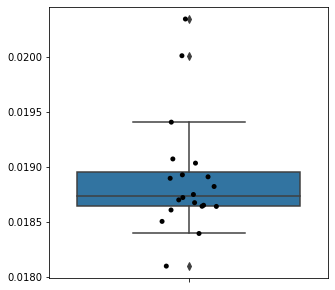

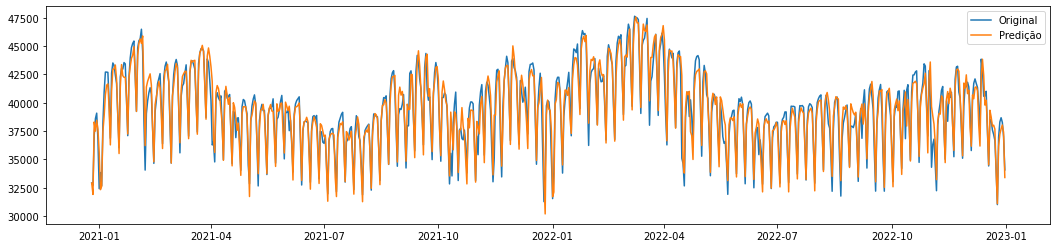

In [93]:
save_results(results_folder + '/df_diff_MA', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

# Analysis

In [ ]:
import os
import json
from matplotlib import font_manager

ts_id = {'df_norm': 1, 'df_fit_curve': 2, 'df_trend_diff': 3, 'df_desazon_MA': 4, 'df_desazon_pad': 5,
         'df_fit_MA': 6, 'df_fit_pad': 7, 'df_diff_MA': 8, 'df_diff_pad': 9}

df_mse = pd.DataFrame()
df_mape = pd.DataFrame()
for df_name in os.listdir('results/'):
    with open(f'results/{df_name}/metrics.json') as jsonfile:
       dict_values = json.load(jsonfile)
       df_mse[ts_id[df_name]] = dict_values['mse_list']
       df_mape[ts_id[df_name]] = dict_values['mape_list']

df_mse = df_mse[range(1,10)]
df_mape = df_mape[range(1,10)]

In [ ]:


# Register Times New Roman font
font_path = 'times.ttf'  # Replace with the actual path to the font file
font_manager.fontManager.addfont(font_path)

# Set font family to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

sns.set_style("whitegrid")

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'MSE regarding each method for 20 simulations'}, xlabel='ID method', ylabel='MSE'>

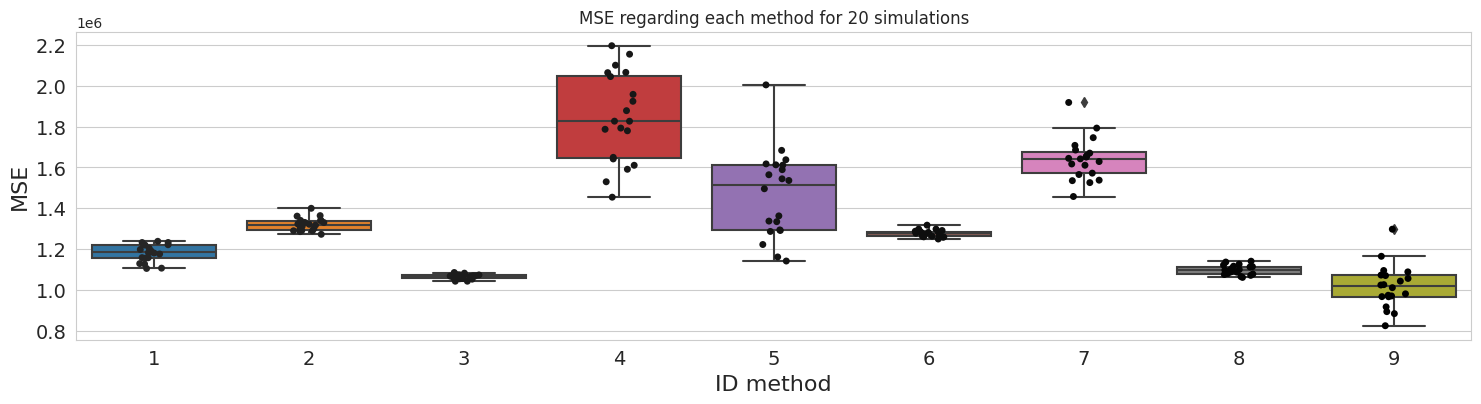

In [ ]:
plt.figure(figsize=(18,4))
sns.boxplot(data=df_mse)
plt.xlabel('ID method', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MSE regarding each method for 20 simulations')
sns.stripplot(data = df_mse, color = 'black')

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'MAPE regarding each method for 20 simulations'}, xlabel='ID method', ylabel='MAPE'>

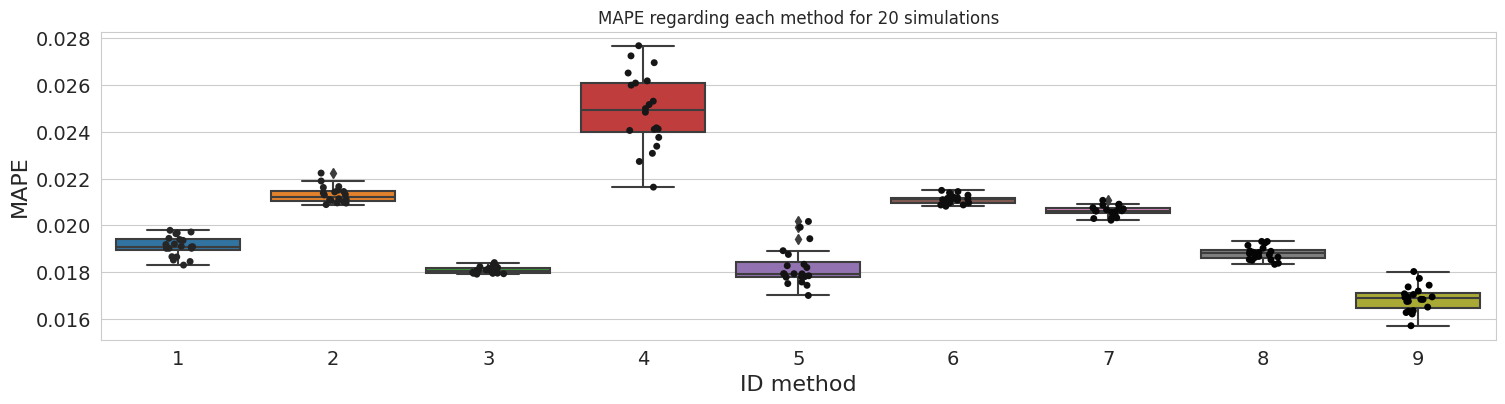

In [ ]:
plt.figure(figsize=(18,4))
sns.boxplot(data=df_mape)
plt.xlabel('ID method', fontsize=16)
plt.ylabel('MAPE', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MAPE regarding each method for 20 simulations')
sns.stripplot(data = df_mape, color = 'black')

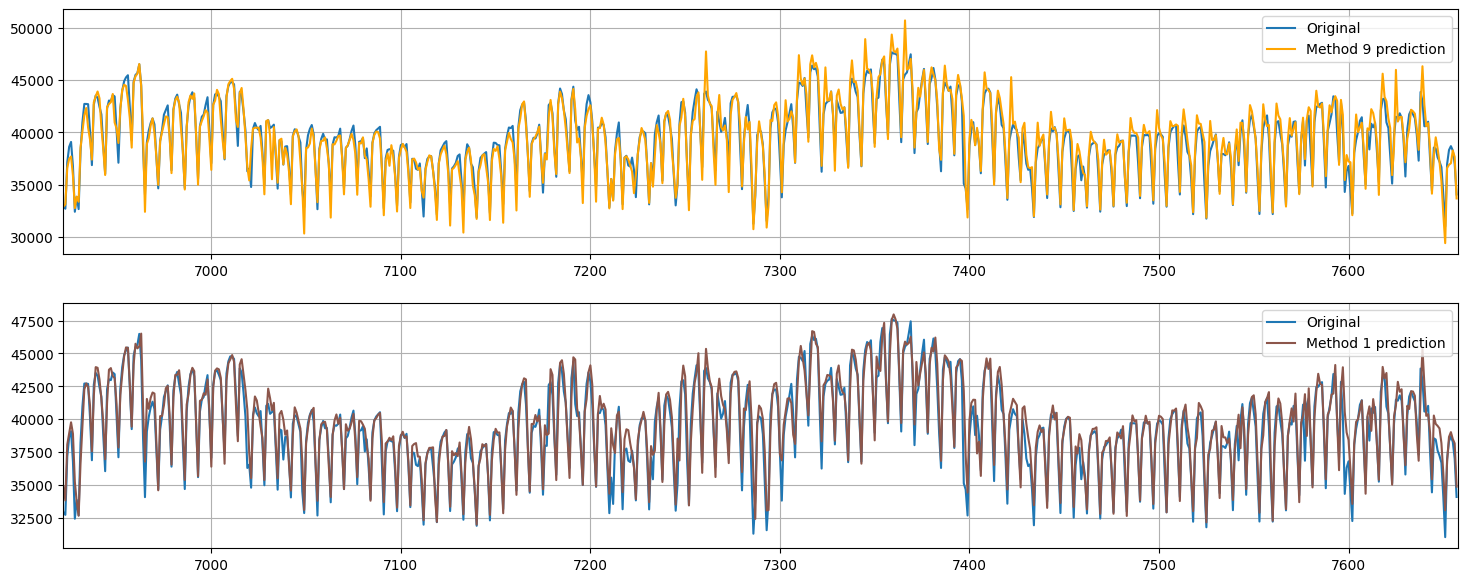

In [ ]:
from cycler import cycler

df_pred_method10 = pd.read_pickle('results/df_diff_pad/predicted.pkl')
df_pred_method1 = pd.read_pickle('results/df_norm/predicted.pkl')
df = df_test

fig, ax = plt.subplots(2, 1, figsize=(18,7))
initial_date = df_pred_method10['data'].iloc[0]
final_date = df_pred_method10['data'].iloc[-1]
mask_date = (df['data'] >= initial_date) & (df['data'] <= final_date)

ax[0].set_prop_cycle(color=['#1f77b4', 'orange'])
ax[0].plot(range(len(df_train)+len(df_val)+30, len(data)), df[mask_date]['carga'])
ax[0].plot(range(len(df_train)+len(df_val)+30, len(data)), df_pred_method10['carga'])
ax[0].legend(['Original', 'Method 9 prediction'])
ax[0].set_xlim(len(df_train)+len(df_val)+30, len(data))
ax[0].grid()

ax[1].set_prop_cycle(color=['#1f77b4', '#8c564b'])
ax[1].plot(range(len(df_train)+len(df_val)+30, len(data)), df[mask_date]['carga'])
ax[1].plot(range(len(df_train)+len(df_val)+30, len(data)), df_pred_method1['carga'])
ax[1].legend(['Original', 'Method 1 prediction'])
ax[1].set_xlim(len(df_train)+len(df_val)+30, len(data))
ax[1].grid()